# Projekt Eksploracji Danych Youtube Trending - Checkpoint 2

### Maria Naklicka    
127313 ISWD

### Norbert Schlaffke 
127201 ISWD

### Control variables

In [0]:
DOWNLOAD_IMAGES = False # Set if want to download thunbail images
RUN_DETECTION = False # Set if want to run object detection 
RES_NET = False
BATCH_SIZE = 1024
NOTEBOOK_VERSION = 0 # Change to re-run cached function

## Libraries import

In [9]:
import pandas as pd
import urllib
import csv
import matplotlib.pyplot as plt
import matplotlib.style as style 
from urllib.error import HTTPError
from google.colab import drive
from joblib import Memory
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
from pathlib import Path
from os import listdir
import cv2
!pip install cvlib
import cvlib as cv
from cvlib.object_detection import draw_bbox
from tqdm.auto import tqdm  
tqdm.pandas()
import multiprocessing as mp
from skimage import io
import sys
import seaborn as sns

In [0]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot')
plt.rcParams["axes.grid"] = False

## Helpers

### Progress bar

In [0]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

### Variables and sizes printing

In [0]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def used_variables():
  for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                          key= lambda x: -x[1])[:10]:
      print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

## Google Drive

In [13]:
# Mount google drive and load data
print('Connecting google drive...')
drive.mount('/content/drive')

drive_path = "/content/drive/My Drive/"
data_path = os.path.join(drive_path , 'datasets/youtube_data')
image_path = os.path.join(data_path, 'images')
# Set cache
print('Setting cache...')
memory = Memory(cachedir=drive_path + '/cache', verbose=0)

Connecting google drive...
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Setting cache...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/content/drive/My Drive//cache'", use "location='/content/drive/My Drive//cache'" instead.
  if __name__ == '__main__':


## Data loading

In this part of project, we will be considering thumbnails of videos. As some films appear several times in the data, we will limit the list to the first occurrence of each film.

In [14]:
data = pd.read_csv(data_path + "/videos_5p.csv", sep=";")
data = data.drop_duplicates(subset='video_id', keep='first')
data.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,Jw1Y-zhQURU,17.14.11,John Lewis Christmas Ad 2017 - #MozTheMonster,John Lewis,NaN,2017-11-10T07:38:29.000Z,"christmas|""john lewis christmas""|""john lewis""|...",7224515,55681,10247,9479,https://i.ytimg.com/vi/Jw1Y-zhQURU/default.jpg,False,False,False,Click here to continue the story and make your...
1,3s1rvMFUweQ,17.14.11,Taylor Swift: …Ready for It? (Live) - SNL,Saturday Night Live,NaN,2017-11-12T06:24:44.000Z,"SNL|""Saturday Night Live""|""SNL Season 43""|""Epi...",1053632,25561,2294,2757,https://i.ytimg.com/vi/3s1rvMFUweQ/default.jpg,False,False,False,Musical guest Taylor Swift performs …Ready for...
2,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,NaN,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787420,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...


In [15]:
len(data)

8606

## Downloading thumbnails 

In [0]:
# If you want to download data - change this cell's type to 'Code' and run it

if DOWNLOAD_IMAGES:
  out = display(progress(0, len(data)), display_id=True)
  failed_links = []
  for i, (index, row) in enumerate(data.iterrows()):
    out.update(progress(i, len(data)))
    try:
        urllib.request.urlretrieve(row['thumbnail_link'], data_path + "/images/thumbnails/"+row['video_id']+'.jpg')
    except HTTPError:
        failed_links.append(row['video_id'])
        
  with open(data_path + '/failed_thumbnails.txt', 'w') as file:
      wr = csv.writer(file, quoting=csv.QUOTE_ALL)
      wr.writerow(failed_links)

In [0]:
failed_indexes = pd.read_csv(data_path + "/failed_thumbnails.txt").transpose()
failed_indexes = failed_indexes.reset_index()
len(failed_indexes)

680 images were not found. Let's check if this fact is linked with attribute `video_error_or_removed`.

In [0]:
failed_data = data.loc[data['video_id'].isin(failed_indexes['index'])]
plt.pie(failed_data.video_error_or_removed.value_counts()/failed_data.video_error_or_removed.count(),
        labels=["No error", "Error"], 
        autopct='%1.1f%%');
plt.title('Video error or removed');

The lack of image is not linked with `video_error_or_removed` attribute.

## Attributes created from the image

Pomysły:
* **ResNet** - wyciągnąć ficzery z ostatniej warstwy wytrenowanego ResNetu
* **HOG** - [Histogram of oriented gradients](https://www.learnopencv.com/histogram-of-oriented-gradients/)


### ResNet18

#### Loading data

Normalized with data from [link](https://pytorch.org/docs/stable/torchvision/models.html)

In [0]:
if RES_NET:

  transform = transforms.Compose([
      transforms.Resize((90, 120)), # There are some images of different size 
      transforms.ToTensor(),    
      transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
      )        
  ])

  dataset = datasets.ImageFolder(
      image_path, 
      transform=transform
    )

  # dataloader is an iterable, 
  # while iterating gives batch_of_images, vector of classes (in this case vector of 0s) 
  
  dataloader = torch.utils.data.DataLoader(
      dataset, 
      batch_size=BATCH_SIZE, 
      shuffle=False, 
      num_workers=os.cpu_count()
    ) 

#### Example images

In [0]:
if RES_NET: 
  def imshow(inp):
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)

  data_iter = iter(dataloader)
  images, _ = data_iter.next()
  imshow(torchvision.utils.make_grid(images[:6], nrow=3))
  plt.title("Example thumbnails");

#### Normalize by channel

In [0]:
# data, _ = iter(dataloader).next()
# data.size()


In [0]:
# img_np = data.numpy()
# type(img_np)

In [0]:
# per_channel_mean = np.mean(img_np, axis=(0,2,3))
# per_channel_std = np.std(img_np, axis=(0,2,3))
# print('Per channel mean: ', per_channel_mean)
# print('Per channel std: ', per_channel_std)

In [0]:
# This can be done by transforms.normalize()
# a, b, c, d = img_np.shape
# for i in range(3):
#   img_np_norm = (img_np[:,i,...] - per_channel_mean[i])/per_channel_std[i]
#   img_np[:,i,...] = img_np_norm

In [0]:
# per_channel_mean = np.mean(img_np, axis=(0,2,3))
# per_channel_std = np.std(img_np, axis=(0,2,3))
# print('Per channel mean: ', per_channel_mean.round(decimals=2))
# print('Per channel std: ', per_channel_std.round(decimals=2))

#### Feature extraction

Turn **ResNet18** into a feature extractor

**ResNet18** [paper](https://arxiv.org/abs/1512.03385)

In [0]:
if RES_NET:
  
  model = models.resnet18(pretrained=True)
  num_ftrs = model.fc.in_features
  print("Number of features: ", num_ftrs)
  model.fc = nn.Sequential()

Last layer of **ResNet18** will give us 512 features for every image

In [0]:
if RES_NET:
  
  if not(torch.cuda.is_available()):
    raise RuntimeError('No GPU acceleration')

  device = torch.device("cuda")

  # Switch model from CPU to GPU
  model = model.cuda() 

  # Switch model to 'Evaluation' mode (affects stuff such as backprop)
  model = model.eval() 

  features = np.empty((len(dataset), num_ftrs))
  added = 0
  out = display(progress(0, len(data)), display_id=True)

  with torch.no_grad():
    for batch, _ in dataloader:
      batch = batch.to(device)
      batch_features = model.forward(batch).cpu().numpy()
      features[added:added+len(batch_features)] = batch_features
      added += len(batch_features)
      out.update(progress(added, len(dataset)))

In [0]:
if RES_NET:
  
  files = np.array(dataset.imgs)[:,0]
  codes = [Path(f).stem for f in files]
  features = dict(zip(codes, features))
  data['resNet_vec'] = data.video_id.apply(
      lambda x: features[x] if x != np.NaN and x in features else np.NaN
    )
  percentage = data.resNet_vec.isnull().sum()/data.resNet_vec.count()*100
  print('Missing: %.2f%%' % percentage)

Features are stored in `resNet_vec` attribute  
**8.55%** of data doesn't have the thunmbail => doesn't have the image features 

### **HOG** - Histogram of oriented gradients 

[Algorithm](https://www.learnopencv.com/histogram-of-oriented-gradients):
 * Select _patch size_ for **HOGs** to be calculated and generate _patches_
 * Calculate _image gradients_ (might be by _sobel_ filter) _cell-wise_
 * Calculate _magnitudes_ and _directions_ of gradients _cell-wise_
 * Generate _histograms_ _cell-wise_
 * Normalize _histograms_ by _blocks of cells_

#### Calculate Gradients

In [0]:
img = cv2.imread('/content/drive/My Drive/datasets/youtube_data/images/thumbnails/qhuKvMRqsk8.jpg')
img = np.float32(img)/255

gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)

Gradients visualised

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


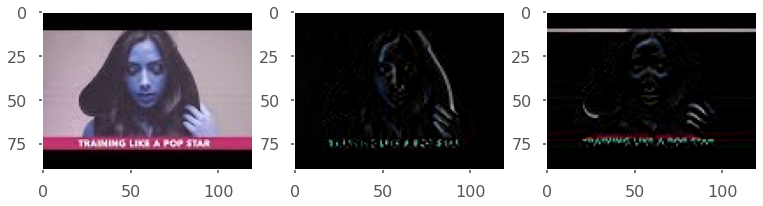

In [0]:
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(gx)
plt.subplot(133)
plt.imshow(gy)

Gradients _magnitudes_ and edge _directions_ (normals to the tangents in points)

In [0]:
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

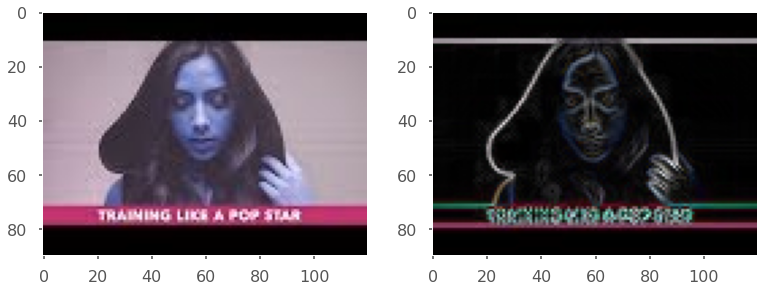

In [0]:
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mag)

#### **HOG** calculation with **OpenCV**



At this point I realised that **HOG** already had been implemented in **OpenCV**...  
Used code from [here](https://stackoverflow.com/a/37005437/5552709)

In [0]:
def get_hog_features(img, cell_size=(4, 4), block_size=(2, 2), nbins=9): 
  """Gets HOG features for given image

  Parameters
  ----------
  img : numpy.ndarray
      Image read by: cv2.cvtColor(cv2.imread(FILE),cv2.COLOR_BGR2GRAY)
  cell_size : tuple, optional
      Tuple in a form (h, w) in pixels. Gradients are calculated in windows
      of this size
  block_size : tuple, optional: 
      Tuple in a form (h, w) in number of cells.
      Gradients are normalized in blocks.
  nbins: integer, optional:
      Number of orientation bins
  Returns
  -------
  numpy.ndarray
      An array of HOGs
  """
  # winSize is the size of the image cropped to an multiple of the cell size
  hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                    img.shape[0] // cell_size[0] * cell_size[0]),
                          _blockSize=(block_size[1] * cell_size[1],
                                      block_size[0] * cell_size[0]),
                          _blockStride=(cell_size[1], cell_size[0]),
                          _cellSize=(cell_size[1], cell_size[0]),
                          _nbins=nbins)

  n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])
  hog_feats = hog.compute(img)\
                .reshape(n_cells[1] - block_size[1] + 1,
                          n_cells[0] - block_size[0] + 1,
                          block_size[0], block_size[1], nbins) \
                .transpose((1, 0, 2, 3, 4))  # index blocks by rows first
  # hog_feats now contains the gradient magnitudes for each direction,
  # for each cell of its group for each group. Indexing is by rows then columns.

  gradients = np.zeros((n_cells[0], n_cells[1], nbins))

  # count cells (border cells appear less often across overlapping groups)
  cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

  for off_y in range(block_size[0]):
      for off_x in range(block_size[1]):
          gradients[off_y:n_cells[0] - block_size[0] + off_y + 1,
                    off_x:n_cells[1] - block_size[1] + off_x + 1] += \
              hog_feats[:, :, off_y, off_x, :]
          cell_count[off_y:n_cells[0] - block_size[0] + off_y + 1,
                    off_x:n_cells[1] - block_size[1] + off_x + 1] += 1

  # Average gradients
  gradients /= cell_count
  return gradients

def get_hog_for_row(video_id):
  path = os.path.join(image_path, 'thumbnails', video_id) + '.jpg'
  if not(os.path.exists(path)):
    return np.NaN
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  return get_hog_features(img)

@memory.cache
def get_hog():
  return data.video_id.progress_apply(get_hog_for_row)

In [0]:
data['hog_vec'] = get_hog()

In [0]:
data['hog_vec'].tail()

79626    [[[0.0, 0.0, 0.0, 0.0, 0.5236944556236267, 0.0...
79627    [[[0.13079702854156494, 0.025874169543385506, ...
79628    [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
79631    [[[0.023807579651474953, 0.014292697422206402,...
79633    [[[0.06320102512836456, 0.036554235965013504, ...
Name: hog_vec, dtype: object

#### Example of **HOG**

In [0]:
def visualize_hog(img_path):
  img = cv2.cvtColor(cv2.imread(img_path),
                   cv2.COLOR_BGR2GRAY)
    # Preview
  gradients = get_hog_features(img)
  plt.figure()
  plt.subplot(121)
  plt.imshow(img, cmap='gray')
  bin = 5  # angle is 360 / nbins * direction
  plt.subplot(122)
  plt.pcolor(gradients[:, :, bin])
  plt.gca().invert_yaxis()
  plt.gca().set_aspect('equal', adjustable='box')
  plt.colorbar()
  plt.show()

thumbnails_path = os.path.join(image_path, 'thumbnails')
sample_images = ['qhuKvMRqsk8', '_0Wz8e4W-oE', '_ASpoeFRTZ0', '_iGAptGAweo', '_IoOJu2_FKE', 
                 '_w58R1OGQFA', '0C3pC-uonZU', '0mAS2Gxs08w', '0noUI5HLY4I' ]
sample_images = [os.path.join(thumbnails_path, x) + '.jpg' for x in sample_images]
sample_images = iter(sample_images)

**HOG** in current configurantion gives 5940 features for each image:
 * **22** rows
 * **30** columns
 * **9** bins for angles

In [0]:
img = cv2.cvtColor(cv2.imread(os.path.join(thumbnails_path, next(sample_images))), cv2.COLOR_BGR2GRAY)

gradients = get_hog_features(img)
print('Number of HOG features: ', np.prod(gradients.shape))
print('Feature matrix shape:', gradients.shape)

Number of HOG features:  5940
Feature matrix shape: (22, 30, 9)


Example 1

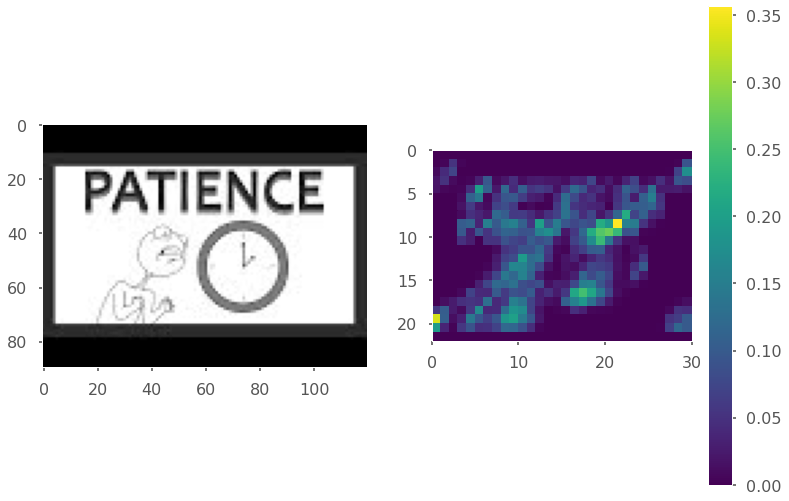

In [0]:
visualize_hog(next(sample_images))

Example 2

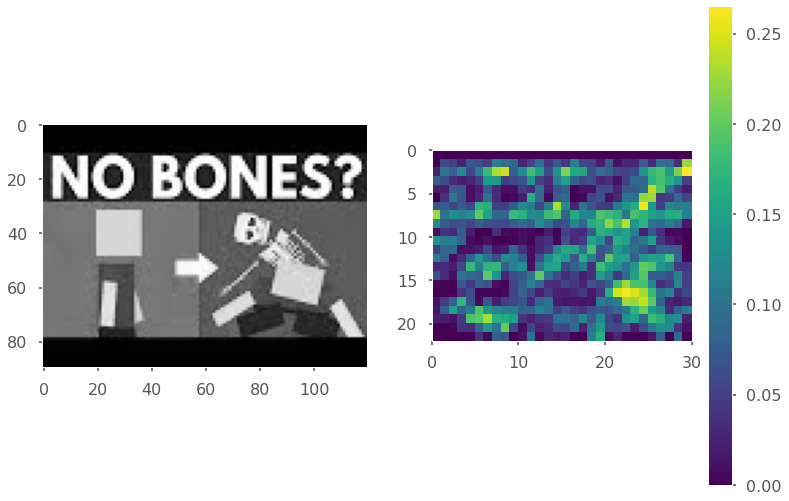

In [0]:
visualize_hog(next(sample_images))

Example 3

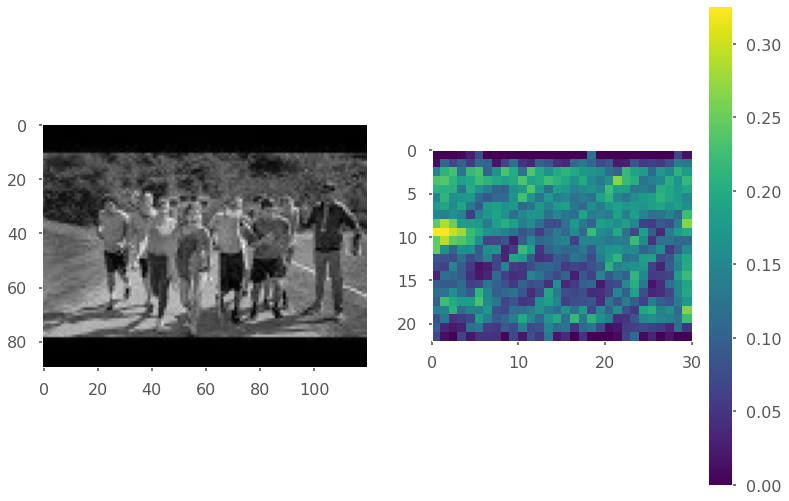

In [0]:
visualize_hog(next(sample_images))

### Object Recognition

Before using the library for object recognition, we chcecked it on sample data:

In [0]:
sample_images = ['_0Wz8e4W-oE', '_ASpoeFRTZ0', '_iGAptGAweo', 
                 '_IoOJu2_FKE', '_w58R1OGQFA', '0C3pC-uonZU', 
                 '0mAS2Gxs08w', '0noUI5HLY4I', '_5d-sQ7Fh5M' ]

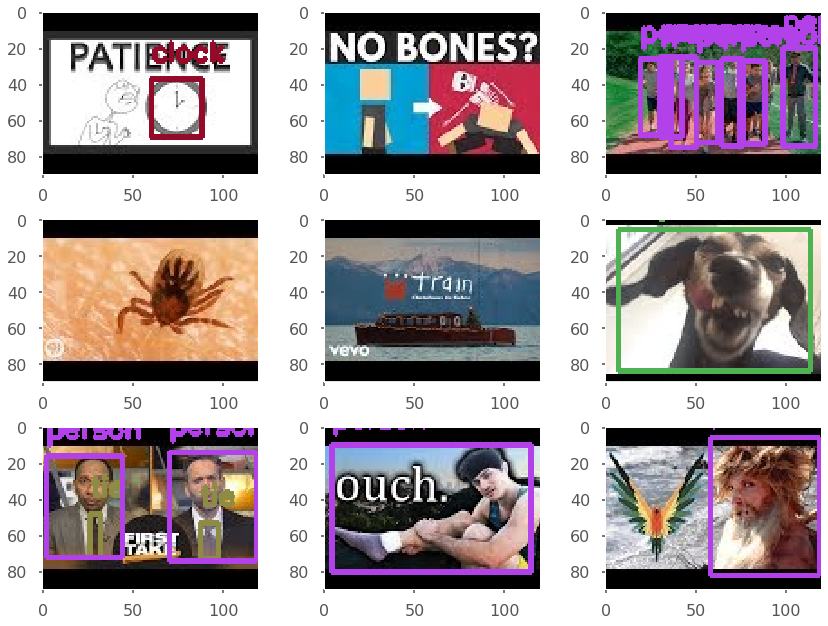

In [0]:
output_images = []
labels = []
for img in sample_images:
  im = cv2.imread(os.path.join(data_path, 'images', 'thumbnails', img + '.jpg'))
  bbox, label, conf = cv.detect_common_objects(im)
  output_image = draw_bbox(im, bbox, label, conf)
  output_images.append(output_image)
  labels.append(label)
fig=plt.figure()
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    io.imshow(cv2.cvtColor(output_images[i-1], cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
labels

[['clock'],
 [],
 ['person', 'person', 'person', 'person', 'person', 'person', 'person'],
 [],
 [],
 ['dog'],
 ['tie', 'tie', 'person', 'person'],
 ['person'],
 ['person']]

#### Recognizing objects on whole dataset

Object recognition works quite well, so we will use it for recognition on the whole dataset:

In [0]:
if RUN_DETECTION:
  img_path = os.path.join(data_path, 'images', 'thumbnails')
  img_names = listdir(img_path)
  objects = []
  i=0
  for name in img_names:
      recognized = dict()
      im = cv2.imread(os.path.join(img_path + name))
      recognized['video_id'] = name
      _, recognized['labels'], recognized['conf'] = cv.detect_common_objects(im)
      objects.append(recognized)

  objects_all = {}
  for d in objects:
      how_many = len(d['labels'])

      for key, val in d.items(): 
          if key not in objects_all:
              objects_all[key] = []

          if how_many == 0:
              if key == 'video_id':
                  objects_all[key].append(val)
              else:
                  objects_all[key].append('NaN')

          for i in range(how_many):
              if key == 'video_id':
                  objects_all[key].append(val)
              else:
                  objects_all[key].append(val[i])

  recognized_objects = pd.DataFrame.from_dict(objects_all)
  recognized_objects.to_csv(os.path.join(data_path, 'recognized_objects.csv'), sep=';')

#### Results analysis

The algorithm is not perfect, so we will consider only these objects, for which confidence is equal or greater than 80%.

In [0]:
objects = pd.read_csv(os.path.join(data_path, 'detected_objects.csv'), sep=';')
objects = objects.loc[objects['conf'] >= 0.8]

In [0]:
objects.head(6)

,video_id,labels,conf
1,-43MBOJnVks,person,0.989490
2,-39ysKKpE7I,person,0.994256
3,-39ysKKpE7I,tie,0.943891
5,-5WBCrazSfg,person,0.822747
6,-66xHRJSPxs,dog,0.962326
7,-66xHRJSPxs,person,0.931500


In [0]:
counts = objects["labels"].value_counts()
print('number of categories: ', len(objects.labels.unique()))
print(counts)

number of categories:  54
person           6628
tie               259
tv                125
dog                60
car                52
cup                37
bottle             25
cell phone         21
cake               16
bicycle            15
laptop             15
truck              13
donut              12
bowl               10
chair               9
potted plant        8
cat                 8
sandwich            7
train               6
horse               6
frisbee             6
bear                5
sports ball         5
pizza               4
stop sign           4
skateboard          3
clock               3
traffic light       3
refrigerator        3
fire hydrant        2
wine glass          2
microwave           2
teddy bear          2
handbag             2
keyboard            2
vase                2
motorcycle          2
backpack            1
boat                1
hot dog             1
giraffe             1
toothbrush          1
bird                1
airplane            1
couch 

There are 54 cattegories of objects. People occur most often on the images, which is not surprising. Some objects occur on one thumbnail only, so we will not consider them in further analysis.

In [0]:
categories = []
for key, val in counts.items():
    if val > 1:
        categories.append(key)

In [0]:
len(categories)

37

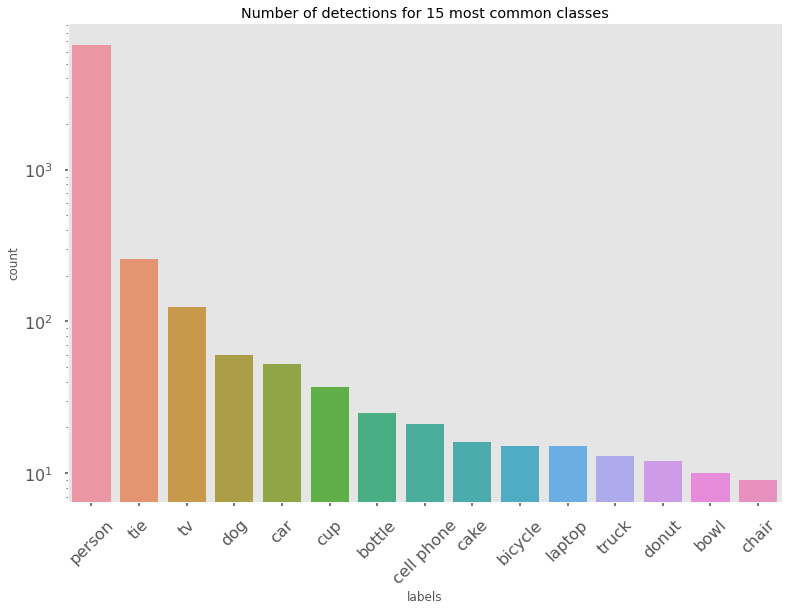

In [0]:
sns.countplot(objects["labels"], order=objects.labels.value_counts().iloc[:15].index, orient="h").set_yscale('log')
plt.xticks(rotation=45)
plt.title('Number of detections for 15 most common classes');

For each image we will construct a vector representation of detected objects. Each position will correspond to one of 37 categories and each value will represent number of objects of the category occuring on given image.

In [0]:
cat_dict = dict()
for i, cat in enumerate(categories):
  cat_dict[cat] = i

In [0]:
def get_objects_vector(vid_id, categories):
  vec = np.zeros((len(categories), 1))
  img = objects.loc[objects['video_id']==vid_id]
  cat_count = img.labels.value_counts()

  for key, val in cat_count.items():
    if key in categories:
      index = categories[key]
      vec[index] = val
  
  return vec.flatten().astype(int)

@memory.cache
def def_get_objects_vectors(version):
  return data.progress_apply(lambda row: get_objects_vector(row['video_id'], cat_dict), axis=1)

In [0]:
data['objects'] = def_get_objects_vectors(NOTEBOOK_VERSION)

In [0]:
data['objects']

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3        [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
79626    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
79627    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
79628    [2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
79631    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
79633    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: objects, Length: 8606, dtype: object

### Facial Expression Recognition (FER)

There are a lot of people detected on the images. It could be informative, if we can recognize emotions represented by these people. Firstly, we will check it on sample data

In [0]:
#!pip install git+https://github.com/justinshenk/fer.git
!pip install fer
%tensorflow_version 1.x
import tensorflow as tf
from fer import FER
detector = FER()

In [0]:
output = []
for img in sample_images:
    img = cv2.imread(os.path.join(data_path, 'images', 'thumbnails', img + '.jpg'))
    output.append(detector.detect_emotions(img))

for o in output:
    print(o)

The algorithm didn't detect any emotions. We tested it on larger images and it worked quite well. Probably thumbnails are too small for it to work properly. Therefore, we won't use emotion recognition.

### Optical Character recognition (OCR)

We will also try to use an algorithm for text recognition. We will test Tesseract - the most known OCR solution on sample data. In spite of its popularity it has a big disadvantage - its effectiveness is low if the background is not even and homogenous.

In [0]:
!sudo apt install tesseract-ocr
!pip install pytesseract
from PIL import Image
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (2,899 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

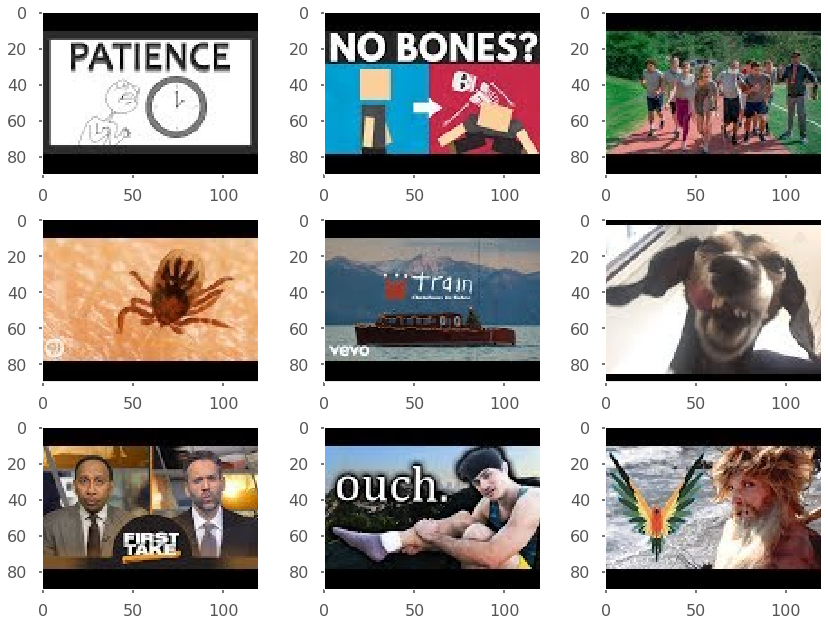

In [0]:
text = []
for img in sample_images:
  ocr_text = pytesseract.image_to_string(
      Image.open(os.path.join(data_path, 'images', 'thumbnails',  img + '.jpg')))
  text.append(ocr_text)
fig=plt.figure()
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    io.imshow(cv2.cvtColor(cv2.imread(os.path.join(data_path, 'images', 'thumbnails', 
                                                   sample_images[i-1] + '.jpg')), cv2.COLOR_BGR2RGB))
plt.show()

In [0]:
print(text)

['PATIENCE', 'NO BONES?\na\n\ni an', '', '', '', '', '', '', '']


Tesseract managed to recognize text on first and second image, which have homogenous backgrounds behind letters. However, on the second image it detected signs, which don't exist. Words on images in the last row aren't identified, even though they are not so difficult cases. 

### Dominant colour

For each image we created two attributes: one containing dominant colour and the second one containing pallette of 6 colours.

In [16]:
!pip install colorthief
from colorthief import ColorThief

In [0]:
def get_dominant_color(id):
  try:
    color_thief = ColorThief(os.path.join(data_path, 'images', 'thumbnails',  id + '.jpg'))
    return color_thief.get_color(quality=1)
  except FileNotFoundError:
    return None

def get_palette(id):
  try:
    color_thief = ColorThief(os.path.join(data_path, 'images', 'thumbnails',  id + '.jpg'))
    return color_thief.get_palette(color_count=6)
  except FileNotFoundError:
    return None

def get_dominant_colors():
    return data.progress_apply(lambda row: get_dominant_color(row['video_id']), axis=1)

def get_palettes():
    return data.progress_apply(lambda row: get_palette(row['video_id']), axis=1)
  

In [20]:
data['dominant_color'] = get_dominant_colors()
data['palette'] = get_palettes()

In [0]:
data.to_csv(os.path.join(data_path, 'colors.csv'), sep=';', index=False, 
            columns=['video_id', 'dominant_color', 'palette'])

### Brightness

In [0]:
from PIL import Image, ImageStat
def brightness( idx ):
    try:
        im = Image.open(os.path.join(data_path, 'images', 'thumbnails', idx + '.jpg')).convert('L')
        stat = ImageStat.Stat(im)
        return stat.mean[0]
    except FileNotFoundError:
        return None

In [0]:
data['brightness'] = data.apply(lambda row: brightness(row['video_id']), axis=1 )
data.to_csv(os.path.join(data_path, 'brightness.csv'), sep=';', index=False, columns=['video_id', 'brightness'])